# WNTR Saltwater Intrusion Tutorial
The following tutorial illustrates the use of storm surge data associated with hurricanes to simulate saltwater intrusion into a drinking water distribution system.  

The analysis uses storm surge data from [EPA's Creating Resilient Water Utilities (CRWU) website](https://epa.maps.arcgis.com/apps/MapSeries/index.html?appid=852ca645500d419e8c6761b923380663), which sources data from [National Oceanic and Atmospheric Administration's (NOAA's) Sea, Lake, and Overland Surge from Hurricanes (SLOSH) model](https://www.nhc.noaa.gov/nationalsurge/). The SLOSH model is used by the National Weather Service to estimate storm surge during hurricanes. To simplify the analysis in this tutorial, the saltwater inundation rate into the drinking water distribution system is assumed to be proportional to the storm surge depth. A more detailed analysis could be pursued by following the methodology laid out by Moglen et al. in their paper titled ["A nexus approach to infrastructure resilience planning under uncertainty"](https://www.sciencedirect.com/science/article/pii/S0951832022005464).

The water network model used in the analysis is KY 4 from the [UKnowledge Water Distribution Systems Research Database](https://uknowledge.uky.edu/wdsrd/). For this tutorial, the model coordinates were changed, so that the network is in a coastal location near Tampa.

# Imports
Import WNTR and other Python packages needed for the tutorial.
- Numpy is required to create and manipulate arrays
- Rasterio is used to load and plot the storm surge data 
- Matplotlib is used to create graphics

In [1]:
import numpy as np
import rasterio as rs
from rasterio.plot import show
import matplotlib.pyplot as plt
import wntr

# Create the water network model

In [2]:
# Create a WaterNetworkModel from an EPANET input (INP) file
network_path = "data/coastal_ky4.inp"
wn = wntr.network.WaterNetworkModel(network_path) 

In [3]:
# Define number of seconds in a day
s_per_day = 24 * 3600 ## unit conversion for seconds per day

# Set the simulation time options to run at hourly time steps for eight days
wn.options.time.hydraulic_timestep = 3600
wn.options.time.quality_timestep = 3600
wn.options.time.duration = 8 * s_per_day

# Set the parameter type for the water quality simulation to chemical 
wn.options.quality.parameter = "CHEMICAL"
# Set the name of the chemical species to NaCl to measure salt levels throughout the simulation
wn.options.quality.chemical_name = "NaCl"

GeoDataFrames are created from the `WaterNetworkModel` using `to_gis`. The GeoDataFrames are used to associate junctions with the storm surge data. The coordinate reference system (CRS) is set to **EPSG:4269 NAD83 / North America** (see https://epsg.io/4269 for more details). 

In [4]:
# Set the CRS to EPSG:4269 NAD83 / North America
wn_gis = wn.to_gis(crs="EPSG:4269")

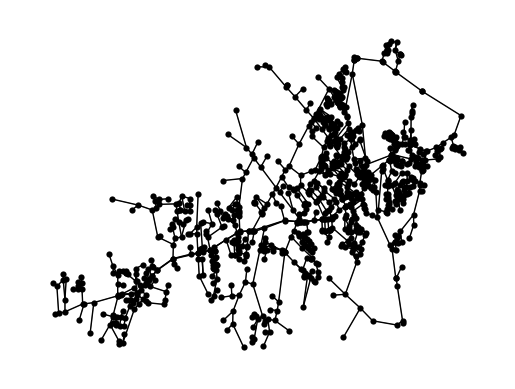

In [5]:
# Plot the network model
ax = wntr.graphics.plot_network(wn)

# Load storm surge data
For the purposes of this tutorial, a subset of the storm surge raster data is used to keep the file size small. To download the entire raster dataset, 
- Navigate to the [NOAA National Storm Surge Risk Maps webpage](https://www.nhc.noaa.gov/nationalsurge/) 
- Scroll down to the "Data Availability and Download" section 
- Select the link labeled "Texas to Maine (high tide scenario)" to obtain a zip file containing the storm surge scenarios
- Unzip the folder and adjust the `raster_path` variable below to point to the folder's location 

In [6]:
# Load the storm surge raster data using the geographic extent of the water network model
# Storm surge refers to the sea water inundation in feet of coastal lands
raster_path = "data/coastal_ky4_storm_surge.tif"

min_lon, min_lat, max_lon, max_lat = wn_gis.junctions.total_bounds

with rs.open(raster_path) as src:
    window = rs.windows.from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform)
    inundation_raster = src.read(1, window=window)
    raster_transform = src.window_transform(window)
    raster_crs = src.crs

In [7]:
# Convert raster data to float to allow for NaN value  
inundation_raster = inundation_raster.astype(float)  
# Convert missing data values (255 indicates no data) to NaN 
inundation_raster[inundation_raster==255] = np.nan 

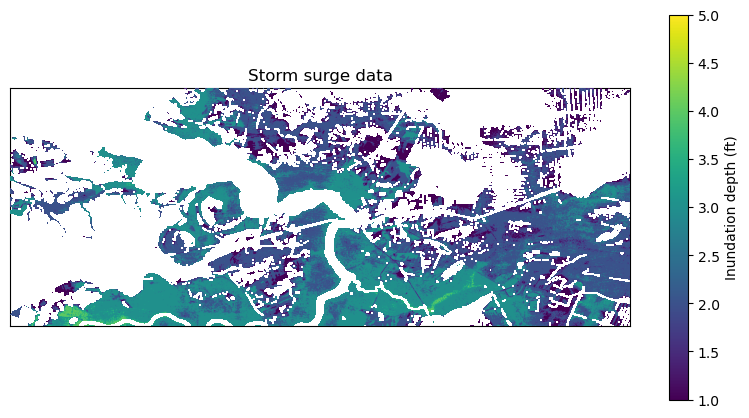

In [8]:
# Plot the storm surge data
fig, ax = plt.subplots(figsize=(10,10))
imshow = show(inundation_raster, transform=raster_transform, ax=ax, zorder=5)
im = imshow.get_images()[0]
tmp = ax.set_title('Storm surge data')
tmp = ax.set_xticks([])
tmp = ax.set_yticks([])
fig.colorbar(im, ax=ax, shrink=0.5, label='Inundation depth (ft)')

# Associate storm surge data with the WaterNetworkModel

WNTR's `sample_raster` function provides a way to associate raster values to point geometries, such as junctions.

In [9]:
# Assign inundation levels to junctions
junctions = wn_gis.junctions
junctions['inundation_level'] = wntr.gis.sample_raster(junctions, raster_path)
# Print the first 5 junctions with their inundation level
print(junctions['inundation_level'].head())

name
J-1      2.0
J-10     NaN
J-100    NaN
J-101    2.0
J-102    NaN
Name: inundation_level, dtype: float64


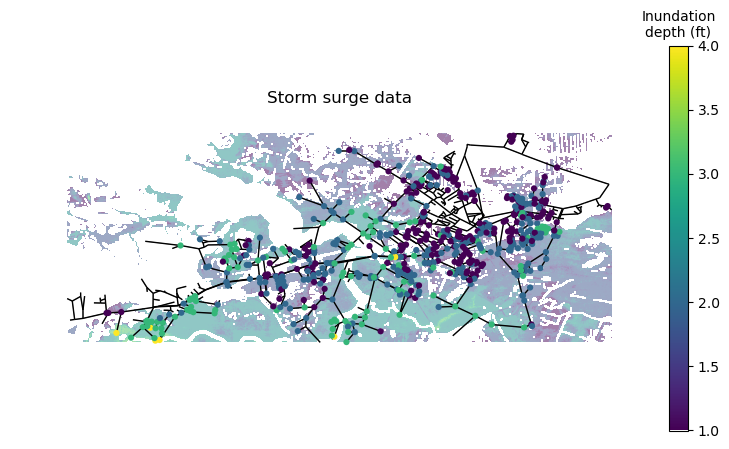

In [10]:
# Plot the storm surge data overlaid with the network model
fig, ax = plt.subplots(figsize=(10,10))

# Plot storm surge data
im = show(inundation_raster, transform=raster_transform, 
          vmin=np.nanmin(inundation_raster), vmax=np.nanmax(inundation_raster), 
          ax=ax, alpha=0.5)
tmp = ax.set_title('Storm surge data')

# Plot junctions with associated inundation level
ax = wntr.graphics.plot_network(wn, node_attribute=junctions["inundation_level"], node_cmap="viridis", ax=ax, node_colorbar_label='Inundation\ndepth (ft)')

# Add saltwater intrusion to the WaterNetworkModel
The analysis uses storm surge values to determine saltwater intrusion across the `WaterNetworkModel`. Saltwater intrusion is simulated using the source quality type "CONCEN", which models saltwater intrusion at the junctions as an injection of salt with different concentrations. The inundation rate (flowrate of sea water into network) is assumed to be proportional to the storm surge depth. The analysis assumes that the storm surge starts at hour 2 and ends at hour 22. The average concentration of salt in sea water is 35 kg/m^3. In this analysis, the inundation level is converted to saltwater concentrations with 0 having no saltwater and 6 having the maximum concentration of salt, which is 35 kg/m^3.

In [11]:
# Estimate the saltwater flowrates using the inundation levels
salt_water_flowrate = junctions["inundation_level"].copy()
salt_water_flowrate[:] = - 0.0001 * salt_water_flowrate[:] # m3/s
# Print the saltwater flowrate for the first 5 junctions only 
print(salt_water_flowrate.head())

name
J-1     -0.0002
J-10        NaN
J-100       NaN
J-101   -0.0002
J-102       NaN
Name: inundation_level, dtype: float64


Text(0.5, 1.0, 'Distribution of saltwater flowrate')

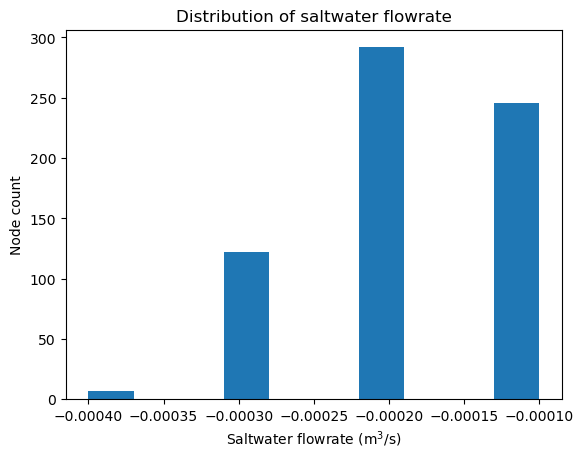

In [12]:
# Plot the distribution of saltwater flowrates
fig, ax = plt.subplots()
ax.hist(salt_water_flowrate)
ax.set_xlabel("Saltwater flowrate (m$^3$/s)")
ax.set_ylabel("Node count")
ax.set_title("Distribution of saltwater flowrate")

In [13]:
# Create a binary pattern, called StormSurge, that starts at hour 2 and ends at hour 22 in the simulation
# This pattern is used to simulate the injection of salt into the network
storm_start = 2*3600
storm_end = 22*3600
source_pattern = wntr.network.elements.Pattern.binary_pattern('StormSurge',
    start_time=storm_start, end_time=storm_end, duration=wn.options.time.duration,
    step_size=wn.options.time.pattern_timestep)

# Add the pattern, StormSurge, to the water network model
wn.add_pattern('StormSurge', source_pattern)

In [14]:
# Define inundated junction, which is junction with saltwater flowrate less than zero  
inundated = salt_water_flowrate < 0.0
salt_water_conc = 35 # kg/m3 
# Add a salt injection source at each inundated junction 
# Saltwater concentration is used to define the salt concentration injected
# Saltwater flowrate is used as the injection rate 
# StormSurge pattern is used to define the hours for which the injection occurs 
for junction_name in wn.junction_name_list:
    if inundated[junction_name]:
        junction = wn.get_node(junction_name)
        wn.add_source(f'Source_{junction_name}', junction_name, 'CONCEN', salt_water_conc, 'StormSurge')
        junction.add_demand(base=salt_water_flowrate[junction_name], pattern_name='StormSurge')

# Simulate the baseline storm surge scenario

In [15]:
# Simulate the hydraulics and water quality for the baseline scenario
sim = wntr.sim.EpanetSimulator(wn)
# Extract the water quality results (i.e., salt concentration in kg/m^3)
baseline_results = sim.run_sim()
baseline_quality = baseline_results.node['quality']
baseline_quality.index = baseline_quality.index / s_per_day ## converts to days
# Print the junction salt concentration for the first 5 timesteps only 
print(baseline_quality.head())

name           J-1  J-10     J-100      J-101  J-102  J-103  J-104  J-105  \
0.000000  0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
0.041667  0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
0.083333  0.000000   0.0  0.000000   0.000000    0.0    0.0    0.0    0.0   
0.125000  1.386737   0.0  0.001646   6.234949    0.0    0.0    0.0   35.0   
0.166667  3.360756   0.0  0.023401  12.340333    0.0    0.0    0.0   35.0   

name         J-106      J-107  ...      J-99  I-Pump-1  O-Pump-2  O-Pump-1  \
0.000000  0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
0.041667  0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
0.083333  0.000000   0.000000  ...   0.00000       0.0       0.0       0.0   
0.125000  2.495438  17.458763  ...   4.48945       0.0       0.0       0.0   
0.166667  6.519385  17.458763  ...  12.33990       0.0       0.0       0.0   

name      I-Pump-2  R-1       T-1       T-2       T-3       T-4  
0.

Text(0, 0.5, 'Saltwater concentration (kg/m$^3$)')

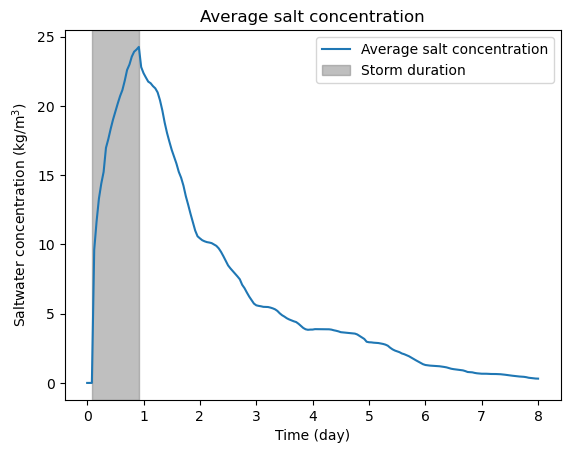

In [16]:
# Plot the average salt concentration in the network over time
fig, ax = plt.subplots()
baseline_quality.mean(axis=1).plot(ax=ax, label="Average salt concentration")
ax.axvspan(storm_start/s_per_day, storm_end/s_per_day, color='grey', alpha=0.5, label="Storm duration")
ax.legend()
ax.set_title("Average salt concentration")
ax.set_xlabel("Time (day)")
ax.set_ylabel("Saltwater concentration (kg/m$^3$)")

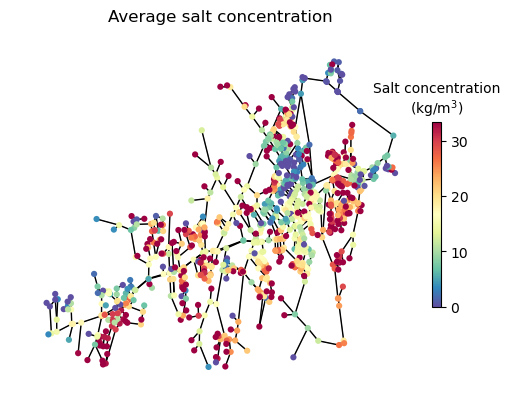

In [17]:
# Plot the average salt concentration for each junction of the network during the storm surge
avg_salt_water = baseline_quality.loc[storm_start/s_per_day:storm_end/s_per_day].mean(axis=0)
ax = wntr.graphics.plot_network(wn, node_attribute=avg_salt_water, node_colorbar_label="Salt concentration\n(kg/m$^3$)", title="Average salt concentration")
tmp = ax.set_xticks([])
tmp = ax.set_yticks([])

# Investigate response actions to saltwater intrusion scenario
Hydrant flushing can be a response action to remove saltwater from the network. For this tutorial, the hydrant locations are randomly identified, but other identification methods could also be used (e.g., predefined list from a geographich information system (GIS) layer).

In [18]:
# Generate random locations for 5 hydrants in the network
np.random.seed(1234)
number_of_hydrants = 5

hydrant_nodes = list(np.random.choice(wn.junction_name_list, number_of_hydrants))

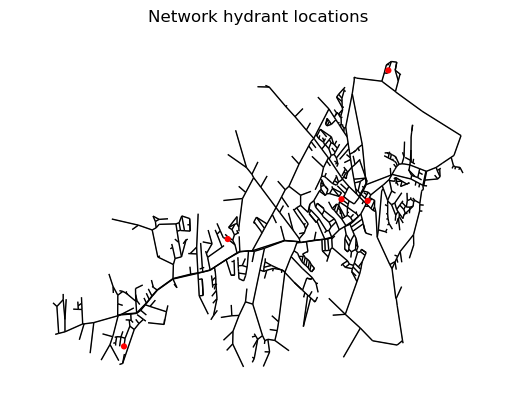

<Axes: title={'center': 'Network hydrant locations'}>

In [19]:
# Plot the locations of hydrants in the network
wntr.graphics.plot_network(wn, node_attribute=hydrant_nodes, title="Network hydrant locations")

In [20]:
# Define the hydrant flushing rate and duration
flushing_rate = 0.126 # 2000 gal/min
hydrant_start = storm_end
hydrant_end = storm_end + 72 * 3600

# Add the hydrant flushing rate to the hydrant locations in the network
for hydrant_node in hydrant_nodes:
    junction = wn.get_node(hydrant_node)
    junction.add_fire_fighting_demand(wn, flushing_rate, hydrant_start, hydrant_end)

In [21]:
# Simulate the hydraulics and water quality for the flushing response 
sim = wntr.sim.EpanetSimulator(wn)
response_results = sim.run_sim()
# Extract the water quality results (i.e., salt concentration in kg/m^3) 
response_quality = response_results.node['quality']
response_quality.index = response_quality.index / s_per_day
# Print the junction salt concentration for the 5 timesteps after flushing starts 
print(response_quality.iloc[22:27,:])

name            J-1       J-10      J-100      J-101  J-102      J-103  J-104  \
0.916667  29.220205  26.002686  20.262058  34.999977    0.0  19.348145    0.0   
0.958333  17.231712  24.584560   4.443335  34.999977    0.0  19.348145    0.0   
1.000000  18.148466  17.786205   0.436174  34.999977    0.0  19.492432    0.0   
1.041667  15.836995  16.495298   0.436174  34.057713    0.0  19.589951    0.0   
1.083333   8.213308  16.495298   0.436174  29.412521    0.0  21.023182    0.0   

name          J-105      J-106      J-107  ...       J-99  I-Pump-1  O-Pump-2  \
0.916667  35.000027  32.721439  34.998848  ...  34.577599       0.0  1.242342   
0.958333  35.000027  32.418678  34.998848  ...  32.774311       0.0  0.000000   
1.000000  35.000027  29.318781  34.998848  ...  26.703777       0.0  0.000000   
1.041667  35.000027  19.778183  34.998848  ...  13.264832       0.0  0.000000   
1.083333  35.000027   5.462525  34.998848  ...   1.730429       0.0  0.000000   

name      O-Pump-1  I-Pump

Text(0, 0.5, 'Saltwater concentration (kg/m$^3$)')

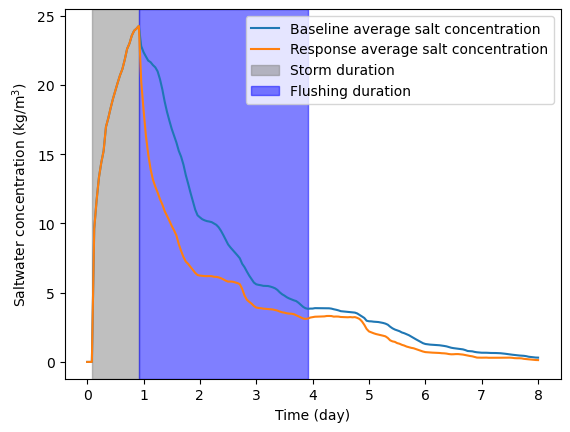

In [22]:
# Plot the average salt concentration over time for the baseline and flushing response scenarios
fig, ax = plt.subplots()
baseline_quality.mean(axis=1).plot(ax=ax, label="Baseline average salt concentration")
response_quality.mean(axis=1).plot(ax=ax, label="Response average salt concentration")
ax.axvspan(storm_start/s_per_day, storm_end/s_per_day, color='grey', alpha=0.5, label="Storm duration")
ax.axvspan(hydrant_start/s_per_day, hydrant_end/s_per_day, color='blue', alpha=0.5, label="Flushing duration")
ax.legend()
ax.set_xlabel("Time (day)")
ax.set_ylabel("Saltwater concentration (kg/m$^3$)")

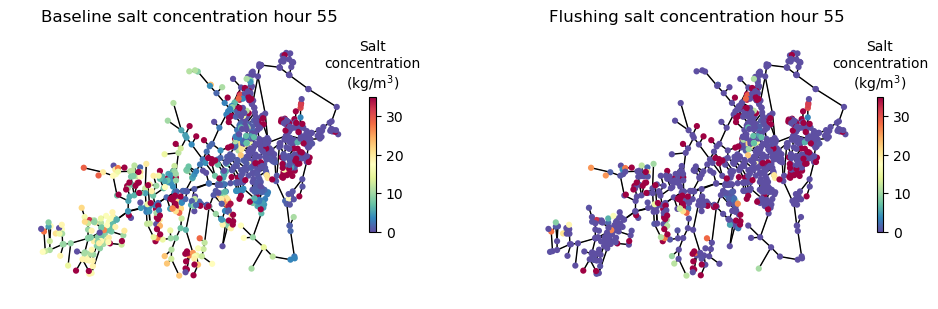

In [23]:
# Plot the salt concentration at each junction of the network for hour 55 in the simulation for both the baseline and flushing scenarios
fig, axes = plt.subplots(1,2, figsize=(12,3.5))
salt_water_55_base = baseline_quality.loc[55/24,:]
ax = wntr.graphics.plot_network(wn, node_attribute=salt_water_55_base, node_colorbar_label="Salt\nconcentration\n(kg/m$^3$)", title="Baseline salt concentration hour 55", show_plot=False, ax=axes[0])
salt_water_55_flush = response_quality.loc[55/24,:]
ax = wntr.graphics.plot_network(wn, node_attribute=salt_water_55_flush, node_colorbar_label="Salt\nconcentration\n(kg/m$^3$)", title="Flushing salt concentration hour 55", show_plot=False, ax=axes[1])

# Save results to CSV files
Save average baseline and response water quality results

In [24]:
baseline_quality.mean(axis=1).to_csv('salt_water_baseline_quality.csv')
response_quality.mean(axis=1).to_csv('salt_water_response_quality.csv')